In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as colors
import ipdb
import platform
opj = os.path.join
deb = ipdb.set_trace
%matplotlib inline
import time

# MRI imports
# -----------
import nibabel as nb
import cortex

subject = '999999'

# Define analysis parameters
# --------------------------
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
if 'aeneas' in platform.uname()[1]:
    base_dir = analysis_info['aeneas_base_folder']
elif 'local' in platform.uname()[1]:
    base_dir = analysis_info['local_base_folder']

fit_model = 'gauss'
deriv_dir = opj(base_dir,'pp_data',subject,fit_model,'deriv')

# Create derivatives flatmaps
# ---------------------------
sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11
mask_dir  = 'pos'

# Get data and combine hemispheres
deriv_mat=[]
for hemi in ['L','R']:
    deriv_file = nb.load(opj(deriv_dir,mask_dir,"prf_deriv_{hemi}_{mask_dir}_fsaverage.func.gii".format(hemi = hemi, mask_dir = mask_dir)))
    deriv_mat.append(np.array([deriv_file.darrays[i].data for i in range(len(deriv_file.darrays))]))
deriv_mat = np.hstack(deriv_mat)
deriv_mat = deriv_mat.T

In [2]:
# import matplotlib.image as mpimg 
# import PIL

# pycortex_config_file = cortex.options.usercfg
# fileIn = open(pycortex_config_file, 'r')
# for line in fileIn:
#     if 'colormaps' in line:
#         cmap_dir = line[11:-1]

# cmap_orig = 'hsv'
# img = mpimg.imread("{cmap_dir}/{cmap_orig}.png".format(cmap_dir = cmap_dir,cmap_orig = cmap_orig)) 
# new_img = np.zeros((img.shape[1],img.shape[1],4))
# new_img = np.float32(new_img)
# for alpha_num, alpha in enumerate(np.linspace(1,0,img.shape[1])):
#     new_img[alpha_num,:,:] = img[0];
#     new_img[alpha_num,:,3] = new_img[alpha_num,:,3]*alpha;    

#     #mpimg.imsave("{cmap_dir}/{cmap_orig}_alpha.png".format(cmap_dir = cmap_dir,cmap_orig = cmap_orig),new_img,vmin=0.0,vmax=1.0)
# map = new_img*255
# map = map.astype(np.uint8)

# im = PIL.Image.fromarray(map, mode='RGBA')
# im.save("{cmap_dir}/{cmap_orig}_alpha.png".format(cmap_dir = cmap_dir,cmap_orig = cmap_orig))


In [7]:
# R-square
rsq_data = deriv_mat[:,rsq_idx]
rsq_data = np.nan_to_num(rsq_data)
rsq_data = rsq_data*255.0
rsq_data = rsq_data.astype(np.uint8)

data4mask = deriv_mat
rsq_data[np.logical_or(np.logical_or(  data4mask[:,rsq_idx]<=0.2,
                                        data4mask[:,cov_idx]<=1/3.0),
                                        data4mask[:,size_idx]<=0.5)] = 0.0


In [11]:
cmap_steps = 16
col_offset = 14/16

pol_comp_num = deriv_mat[:,polar_real_idx] + 1j * deriv_mat[:,polar_imag_idx]
polar_ang = np.angle(pol_comp_num)
norm_polar_data = (polar_ang + np.pi) / (np.pi * 2.0)
norm_polar_data = np.fmod(norm_polar_data + col_offset,1)
norm_polar_data_digit = np.digitize(norm_polar_data,np.linspace(0,1,cmap_steps,endpoint=False))
norm_polar_data_discrete = norm_polar_data_digit/cmap_steps - (1/(cmap_steps*2))
norm_polar_data_discrete = norm_polar_data_discrete*255.0
norm_polar_data_discrete = norm_polar_data_discrete.astype(np.uint8)

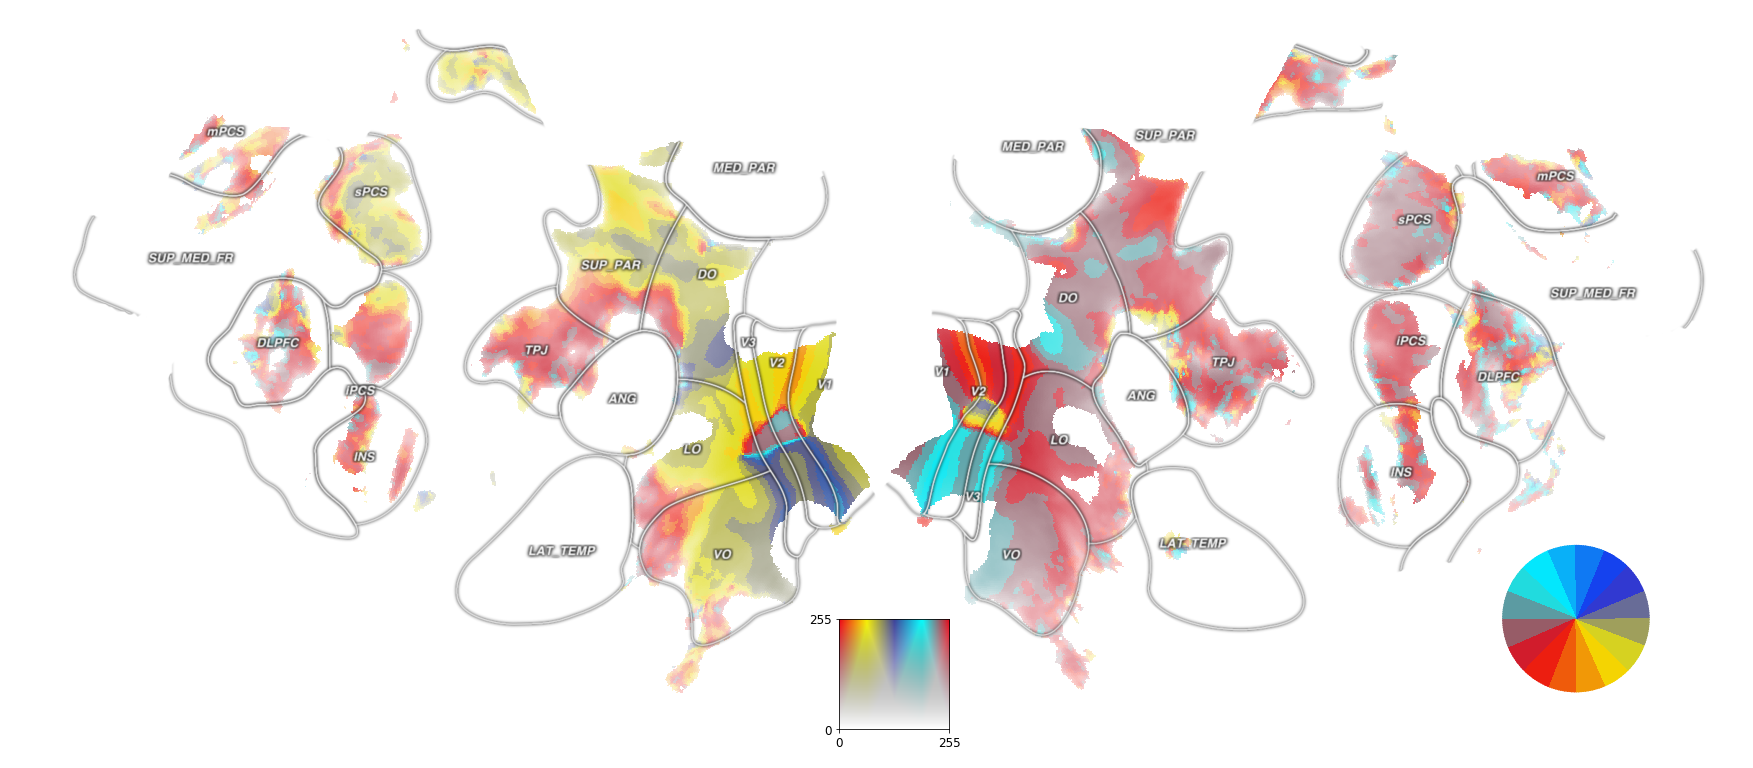

In [66]:
vertex_2d = cortex.Vertex2D(  dim1 = norm_polar_data_discrete, 
                              dim2 = rsq_data,
                              description = 'polar_angle',
                              subject = 'fsaverage', 
                              cmap = 'Retinotopy_RYBCR_alpha', 
                              vmin = 0,
                              vmax = 255,
                              vmin2 = 0,
                              vmax2 = 255,
                         )
vertex2 = cortex.quickshow(braindata = vertex_2d)

# Polar angle color bar
base = cortex.utils.get_cmap('Retinotopy_RYBCR')
val = np.arange(1,cmap_steps+1)/cmap_steps - (1/(cmap_steps*2))
val = np.fmod(val+col_offset,1)
colmap = colors.LinearSegmentedColormap.from_list('my_colmap',base(val),N = cmap_steps)

cbar_axis = vertex2.add_axes([0.5, 0.07, 0.8, 0.2], projection='polar')
norm = matplotlib.colors.Normalize(0, 2*np.pi)
t = np.linspace(0,2*np.pi,200,endpoint=True)
r = [0,1]
rg, tg = np.meshgrid(r,t)
im = cbar_axis.pcolormesh(t, r, tg.T,norm= norm, cmap = colmap)
cbar_axis.set_yticklabels([])
cbar_axis.set_xticklabels([])
cbar_axis.set_theta_zero_location("W")

cbar_axis.spines['polar'].set_visible(False)

img_dir = '/Users/martin/Dropbox/Data/Admin/CNRS/2019/Oral/Keynote/material/'
plt.savefig("{imdir}flat_svg'.pdf".format(imdir = img_dir),facecolor="w")

In [13]:
handle = cortex.webgl.show(data=vertex_2d,recache = True)

Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 3798


In [68]:
img_dir = '/Users/martin/Dropbox/Data/Admin/CNRS/2019/Oral/Keynote/material/'
# to set manually
# take out roi
# curvature brightness: 0.7
# curvature contrast: 0.3
# curvature smoothness: 0.1

flat = {'camera.altitude':0,
        'camera.azimuth':180,
        'camera.radius':300,
        'surface.{subject}.depth':0,
        'surface.{subject}.unfold':1, # 0 for reset 1 for flat
        'surface.{subject}.specularity':0,
                            }
handle._set_view(**flat)
time.sleep(5)

handle.getImage("{imdir}flat.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [70]:
left_hemi_lateral_inflated = {'camera.altitude':90,
                             'camera.azimuth':90,
                             'camera.radius':300,
                             'surface.{subject}.unfold':0.5, # 0 for reset 1 for flat
                             'surface.{subject}.depth':0,
                              'surface.{subject}.left':True,
                             'surface.{subject}.right':False,
                             'surface.{subject}.specularity':0,
                            }
handle._set_view(**left_hemi_lateral_inflated)
time.sleep(5)
handle.getImage("{imdir}left_lateral_inflated.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [71]:
left_hemi_lateral = {'camera.altitude':90,
                     'camera.azimuth':90,
                     'camera.radius':300,
                     'surface.{subject}.unfold':0, # 0 for reset 1 for flat
                     'surface.{subject}.depth':0,
                     'surface.{subject}.left':True,
                     'surface.{subject}.right':False,
                     'surface.{subject}.specularity':0,
                    }
handle._set_view(**left_hemi_lateral)
time.sleep(5)
handle.getImage("{imdir}left_lateral.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [86]:
left_hemi_medial_inflated = {'camera.altitude':90,
                             'camera.azimuth':270,
                             'camera.radius':300,
                             'surface.{subject}.unfold':0.5, # 0 for reset 1 for flat
                             'surface.{subject}.depth':0,
                             'surface.{subject}.left':True,
                             'surface.{subject}.right':False,
                             'surface.{subject}.specularity':0,
                            }
handle._set_view(**left_hemi_medial_inflated)
time.sleep(5)
handle.getImage("{imdir}left_medial_inflated.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [75]:
left_hemi_medial = {'camera.altitude':90,
                     'camera.azimuth':270,
                     'camera.radius':300,
                     'surface.{subject}.unfold':0, # 0 for reset 1 for flat
                     'surface.{subject}.depth':0,
                     'surface.{subject}.left':True,
                     'surface.{subject}.right':False,
                     'surface.{subject}.specularity':0,
                    }

handle._set_view(**left_hemi_medial)
time.sleep(5)
handle.getImage("{imdir}left_medial.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [77]:
right_hemi_lateral = {'camera.altitude':90,
                     'camera.azimuth':270,
                     'camera.radius':300,
                     'surface.{subject}.unfold':0, # 0 for reset 1 for flat
                     'surface.{subject}.depth':0,
                     'surface.{subject}.left':False,
                     'surface.{subject}.right':True,
                     'surface.{subject}.specularity':0,
                    }

handle._set_view(**right_hemi_lateral)
time.sleep(5)
handle.getImage("{imdir}right_lateral.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [78]:
right_hemi_lateral_inflated = {  'camera.altitude':90,
                                 'camera.azimuth':270,
                                 'camera.radius':300,
                                 'surface.{subject}.unfold':0.5, # 0 for reset 1 for flat
                                 'surface.{subject}.depth':0,
                                 'surface.{subject}.left':False,
                                 'surface.{subject}.right':True,
                                 'surface.{subject}.specularity':0,
                                }

handle._set_view(**right_hemi_lateral_inflated)
time.sleep(5)
handle.getImage("{imdir}right_lateral_inflated.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [80]:
right_hemi_medial = {'camera.altitude':90,
                     'camera.azimuth':90,
                     'camera.radius':300,
                     'surface.{subject}.unfold':0, # 0 for reset 1 for flat
                     'surface.{subject}.depth':0,
                     'surface.{subject}.left':False,
                     'surface.{subject}.right':True,
                     'surface.{subject}.specularity':0,
                    }
handle._set_view(**right_hemi_medial)
time.sleep(5)
handle.getImage("{imdir}right_medial.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [82]:
right_hemi_medial_inflated = {   'camera.altitude':90,
                                 'camera.azimuth':90,
                                 'camera.radius':300,
                                 'surface.{subject}.unfold':0.5, # 0 for reset 1 for flat
                                 'surface.{subject}.depth':0,
                                 'surface.{subject}.left':False,
                                 'surface.{subject}.right':True,
                                 'surface.{subject}.specularity':0,
                                }
handle._set_view(**right_hemi_medial_inflated)
time.sleep(5)
handle.getImage("{imdir}right_medial_inflated.png".format(imdir=img_dir),size = (3840, 2160))

[{}]

In [84]:
dorsal_inflated = {   'camera.altitude':90,
                      'camera.azimuth':180,
                      'camera.radius':300,
                      'surface.{subject}.unfold':0.5, # 0 for reset 1 for flat
                      'surface.{subject}.left':True,
                      'surface.{subject}.depth':0,
                      'surface.{subject}.right':True,
                      'surface.{subject}.specularity':0.2,
                                }
handle._set_view(**dorsal_inflated)
time.sleep(5)
handle.getImage("{imdir}dorsal_inflated.png".format(imdir=img_dir),size = (3840, 2160))

[{}]